In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from PIL import Image
import tensorflow as tf
from os.path import join, basename
import scipy.misc
import tqdm as tqdm
from scipy import ndimage as ndi
%matplotlib inline

In [2]:
import SimpleITK as sitk
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening, convex_hull_image
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border

#### Importing annotations and candidates csv files

In [3]:
annotations = pd.read_csv("dataset/annotations.csv")
candidates =pd.read_csv("dataset/candidates_V2/candidates_V2.csv")

#### The candidates file is a csv file that contains nodule candidate per line. Each line holds the scan name, the x, y, and z position of each candidate in world coordi-nates, and the corresponding class.

In [4]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754975 entries, 0 to 754974
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   seriesuid  754975 non-null  object 
 1   coordX     754975 non-null  float64
 2   coordY     754975 non-null  float64
 3   coordZ     754975 non-null  float64
 4   class      754975 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 28.8+ MB


#### The annotation file is a csv file that contains one finding per line. Each line holds the Series Instance UID of the scan, the x, y, and z position of each finding in world coordinates; and the corresponding diameter in mm. The annotation file contains 1186 nodules.

In [5]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   seriesuid    1186 non-null   object 
 1   coordX       1186 non-null   float64
 2   coordY       1186 non-null   float64
 3   coordZ       1186 non-null   float64
 4   diameter_mm  1186 non-null   float64
dtypes: float64(4), object(1)
memory usage: 46.5+ KB


In [6]:
##################### Samples are heavily imbalanced #####################

print(len(candidates[candidates['class'] == 0]))
print(len(candidates[candidates['class'] == 1]))
print ('percentage of positive cases are ' + str(len(candidates[candidates['class'] == 1])*100.0/len(candidates))+" %")

753418
1557
percentage of positive cases are 0.20623199443690188 %


An .mhd file, which is a header file containing metadata describing image properties such as voxel size, matrix size, orientation and position, and a link to the binary image. This file can also contain limited metadata information.

### Load Data

In [7]:
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    image_array = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(itkimage.GetOrigin()))

    # Read the spacing along each dimension
    spacing = np.array(list(itkimage.GetSpacing()))

    return image_array, origin, spacing

In [8]:
luna_path="dataset/complete_data/"
file_list=glob(luna_path+"*.mhd")
output_path_images = "dataset/2d_slices/imgs/"
output_path_masks = "dataset/2d_slices/masks/"

if not os.path.isdir(output_path_images):
    os.makedirs(output_path_images)
if not os.path.isdir(output_path_masks):
    os.makedirs(output_path_masks)

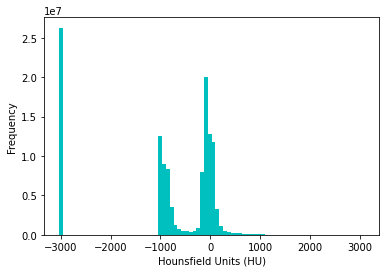

In [9]:
from matplotlib import pyplot as plt
img, origin, spacing = load_itk(file_list[0])
first_patient_pixels = img
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [10]:
def make_mask(center,diam,z,width,height,spacing,origin):
    '''
        Center : centers of circles px -- list of coordinates x,y,z
        diam : diameters of circles px -- diameter
        widthXheight : pixel dim of image
        spacing = mm/px conversion rate np array x,y,z
        origin = x,y,z mm np.array
        z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates
    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int((diam)/spacing[0])
    v_xmin = np.max([0,int(v_center[0]-v_diam)])
    v_xmax = np.min([width,int(v_center[0]+v_diam)])
    v_ymin = np.max([0,int(v_center[1]-v_diam)]) 
    v_ymax = np.min([height,int(v_center[1]+v_diam)])

    v_xrange = range(v_xmin,v_xmax)
    v_yrange = range(v_ymin,v_ymax)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

In [11]:
def matrix2int16(matrix):
    ''' 
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))

In [12]:
# Helper function to get rows in data frame associated with each file
def get_filename(case):
    global file_list
    for f in file_list:
        if case in f:
            return(f)

In [13]:
fcount = 0
no_nodule_ct_scan = []
df_node = annotations
df_node["file"] = df_node["seriesuid"].apply(get_filename)
df_node = df_node.dropna()
print(type(file_list))
for img_file in file_list:
    #get all nodules associate with file
    mini_df = df_node[df_node["file"]==img_file]
    if len(mini_df) == 0:
        no_nodule_ct_scan.append(img_file)
    elif len(mini_df)>0:
        img, origin, spacing = load_itk(img_file)
        for node_idx,anno_row in mini_df.iterrows():
            node_x = anno_row["coordX"]
            node_y = anno_row["coordY"]
            node_z = anno_row["coordZ"]
            diam = anno_row["diameter_mm"]
            center=np.array([node_x,node_y,node_z]) #nodule center
            num_z,height,width = img.shape
            v_center =  np.rint((center-origin)/spacing) 
            #print(imgs.shape)
            #imgs = np.ndarray([0, height, width], dtype=np.float32)
            #masks = np.ndarray([0, height, width], dtype=np.uint8)
            center = np.array([node_x, node_y, node_z])  # nodule center
            v_center = np.rint((center - origin) / spacing)  # nodule center in voxel space (still x,y,z ordering)
            # print("v_center: %s" % v_center)
            for i, i_z in enumerate(np.arange(int(v_center[2]) - 1,
                                              int(v_center[2]) + 2).clip(0,
                                                                         num_z - 1)):  # clip prevents going out of bounds in Z
                # print("i, i_z: %d, %d" % (i, i_z))
                mask = make_mask(center, diam, i_z * spacing[2] + origin[2],
                                 width, height, spacing, origin)
                masks = mask
                imgs = img[i_z]
                middle = imgs[100:400,100:400]
                mean = np.mean(middle)  
                max = np.max(imgs)
                min = np.min(imgs)
                # To improve threshold finding, I'm moving the 
                # underflow and overflow on the pixel spectrum
                imgs[imgs==max]=mean
                imgs[imgs==min]=mean
            np.save(os.path.join(output_path_images, "images_%s_%s.npy" % (anno_row["seriesuid"], int(v_center[2]))), imgs)
            np.save(os.path.join(output_path_masks, "masks_%s_%s.npy" % (anno_row["seriesuid"], int(v_center[2]))), masks)  

<class 'list'>


In [14]:
len(no_nodule_ct_scan)

134

(512,)
Img min: -1024 Img max: 1964


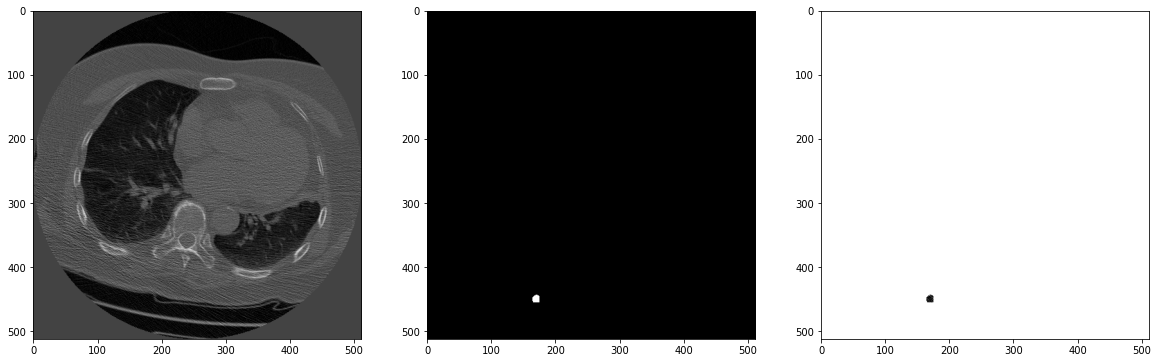

In [15]:
imgs = np.load(output_path_images+'images_1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_57.npy')
print(np.shape(imgs[0]))
print('Img min:',imgs.min(),'Img max:',imgs.max())
# imgs[imgs==imgs.min()] = 0
masks = np.load(output_path_masks+'masks_1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259572521472765997306_96.npy')

plt.figure(figsize=[20,10])
plt.subplot(131)
plt.imshow(imgs,cmap='gray')
plt.subplot(132)
plt.imshow(masks,cmap='gray')
plt.subplot(133)
plt.imshow((imgs)*masks,cmap='gray')